In [1]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b

In [2]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [4]:
print(b1(0.99), b2(0.99))
print(b1(0.999), b2(0.999))

6396.852582070809 6392.63898501517
636936.3717901479 636930.0087515671


In [5]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [6]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    for i, time in enumerate(times):
        sim.integrate(time)
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    massprefac = -1/(m1+m3)
    w2 = massprefac*(alpha23**(5/2)*m1*m2/ec23**2 + alpha12**(1/2)*m2*m3/ec12**2 + alpha12**(1/2)*alpha23**(5/2)*(m1+m3)**2/ec13**2)
    w1 = massprefac*(m_tot * (alpha23**(5/2)*m3/ec23**2 + alpha12**(1/2)*m1/ec12**2))
    k = massprefac * np.sqrt(m1*m2*m3*m_tot) * (alpha23**(5/2)*1/ec23**2 - alpha12**(1/2)*1/ec12**2)
    
    phi = 1/2*np.arctan2(2*k, w2-w1)
    R1 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = np.matmul(R1, R2)
    
    print('Theoretical rotation matrix is')
    print(T.T)
    print('Calculated rotation matrix is')
    print(R)

    Sxapprox = R @ Gx.T
    Syapprox = R @ Gy.T
    
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a, S2a, S3a = np.sqrt(Sxapprox**2 + Syapprox**2)
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

In [7]:
def norun(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    

    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
     
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    massprefac = -1/(m1+m3)
    w2 = massprefac*(alpha23**(5/2)*m1*m2/ec23**2 + alpha12**(1/2)*m2*m3/ec12**2 + alpha12**(1/2)*alpha23**(5/2)*(m1+m3)**2/ec13**2)
    w1 = massprefac*(m_tot * (alpha23**(5/2)*m3/ec23**2 + alpha12**(1/2)*m1/ec12**2))
    k = massprefac * np.sqrt(m1*m2*m3*m_tot) * (alpha23**(5/2)*1/ec23**2 - alpha12**(1/2)*1/ec12**2)

    phi = 1/2*np.arctan2(2*k, w2-w1)
    R1 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R1@R2
    
    return R
    
#     print('Theoretical rotation matrix is')
#     print(T.T)
#     print('Calculated rotation matrix is')
#     print(R)
    
#     print('-------------------------------------------------------------')
#     print('Mdiag eigenvals:', Mdiag[0][0],Mdiag[1][1],Mdiag[2][2])
#     Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
#     Mp = R1 @ Mdiagapprox @ R1.T
#     print('Mapprox eigenvals:', Mp[0][0],Mp[1][1],Mp[2][2])
#     print('Error:', (Mdiag[0][0]-Mp[0][0])/Mdiag[0][0], (Mdiag[1][1]-Mp[1][1])/Mdiag[1][1], (Mdiag[2][2]-Mp[2][2])/Mdiag[2][2])
    
#     print('-------------------------------------------------------------')
#     print('w1:', Mdiagapprox[0,0], w1, (Mdiagapprox[0,0]-w1)/Mdiagapprox[0,0])
#     print('w2:', Mdiagapprox[1,1], w2, (Mdiagapprox[1,1]-w2)/Mdiagapprox[1,1])
#     print('w2-w1:', Mdiagapprox[1,1]-Mdiagapprox[0,0], w2-w1, ((Mdiagapprox[1,1]-Mdiagapprox[0,0])-(w2-w1))/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
#     print('k:', Mdiagapprox[1,0], k, (Mdiagapprox[1,0]-k)/Mdiagapprox[1,0])
    
#     angle = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
#     print('phi:', angle, phi, (angle-phi)/angle)

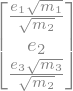

In [8]:
from sympy import *
init_printing()
m1, m2, m3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13, e1, e2, e3 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}, e_1, e_2, e_3", positive=True, real=True)
eps12, eps23, eps13 = symbols(r"\epsilon_{12}, \epsilon_{23}, \epsilon_{13}", positive=True, real=True)

G = Matrix([sqrt(m1/m2)*e1, sqrt(m2/m2)*e2, sqrt(m3/m2)*e3])
G

# The eigenmodes by numerically diagonalizing M

CPU times: user 220 ms, sys: 4.65 ms, total: 225 ms
Wall time: 223 ms


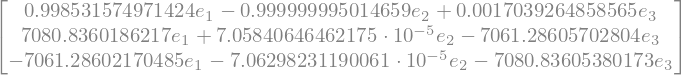

In [9]:
%%time
alpha = 0.999, 0.99
mass = 1e-7,1e-15,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)
ps = sim.particles
lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
M = lsys.Neccentricity_matrix
vals,T = np.linalg.eigh(M)

T.T*G.subs(m1, mass[0]).subs(m2, mass[1]).subs(m3, mass[2])

# R is the theoretical rotation matrix we calculate. Below is the theoretical eigenmodes.

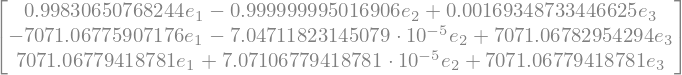

In [10]:
R = norun(sim)
R*G.subs(m1, mass[0]).subs(m2, mass[1]).subs(m3, mass[2])

In [ ]:
alpha = 0.999, 0.99
mass = 1e-7,1e-15,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)
norun(sim)

In [ ]:
times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

In [ ]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1/S1[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2/S2[0], color='green', linestyle='-.', label='S2a')
ax.plot(times, S3/S3[0], color='orange', linestyle='-.', label='S3a')
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1a/S1a[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], color='green', linestyle='-.', label='S2a')
ax.plot(times, S3a/S3a[0], color='orange', linestyle='-.', label='S3a')
ax.legend()

In [ ]:
alpha = 0.76, 0.85
mass = 1e-6,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)
norun(sim)

In [ ]:
times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

In [ ]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], label='G1')
ax.plot(times, G2/G2[0], label='G2')
ax.plot(times, G3/G3[0], label='G3')
ax.plot(times, S1/S1[0], linestyle='--', label='S1')
ax.plot(times, S2/S2[0], linestyle='--', label='S2')
ax.plot(times, S3/S3[0], linestyle='--', label='S3')
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], label='G1')
ax.plot(times, G2/G2[0], label='G2')
ax.plot(times, G3/G3[0], label='G3')
ax.plot(times, S1a/S1a[0], linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], linestyle='-.', label='S2a')
ax.plot(times, S3a/S3a[0], linestyle='-.', label='S3a')
ax.legend()